In [1]:
import numpy as np              # Массивы (матрицы, векторы, линейная алгебра)
import matplotlib.pyplot as plt # Научная графика
%matplotlib inline 
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import seaborn as sns           # Еще больше красивой графики для визуализации данных
import sklearn        


# Банковский маркетинг

 **Цель задачи** - предсказать, подпишется ли клиент на срочный депозит.

**Источник:**

http://archive.ics.uci.edu/ml/datasets/Bank+Marketing (bank.zip)

[Моро и др., 2014] С. Моро, П. Кортез и П. Рита. Подход на основе данных для прогнозирования успеха банковского телемаркетинга. Системы поддержки принятия решений, Elsevier, 62: 22-31, июнь 2014 г.

# Загружаем и предобрабатываем данные 

In [2]:
url='https://raw.githubusercontent.com/Shuvalova-Nastya/ML_homeworks/main/bank-full.csv'
data_raw = pd.read_csv(url, delimiter=';')

data_raw=data_raw.replace("unknown",np.nan)
pd.set_option('max_columns',None)


In [3]:
#Столбцы default, housing, loan, y содержат бинарные значения. Они имеют тип 'Object'. Заменим тип на бинарный.
data_raw['default']=data_raw['default']=='yes'
data_raw['housing']=data_raw['housing']=='yes'
data_raw['loan']=data_raw['loan']=='yes'
data_raw['y']=data_raw['y']=='yes'


In [4]:
#Столбцы job, marital, education, contact, month, poutcome содержат категориальные значения.Они имеют тип 'Object'. 
#Заменим тип на специальный, предназначенный для хранения категориальных значений.
data_raw['job'] = data_raw['job'].astype('category')
data_raw['marital'] = data_raw['marital'].astype('category')
data_raw['education'] = data_raw['education'].astype('category')
data_raw['contact'] = data_raw['contact'].astype('category')
data_raw['month'] = data_raw['month'].astype('category')
data_raw['poutcome'] = data_raw['poutcome'].astype('category')

In [5]:
bool_columns=[c for c in data_raw.columns if data_raw[c].dtype.name == 'bool']
categorical_columns = [c for c in data_raw.columns if data_raw[c].dtype.name == 'category']
numerical_columns   = [c for c in data_raw.columns if data_raw[c].dtype.name == 'int64']

In [6]:
#Пропущенных значений в столбцах poutcome и contact очень много, поэтому удалим эти столбцы. Остальные значения заполним модой.
data_raw=data_raw.drop('poutcome', 1)
data_raw=data_raw.drop('contact', 1)

In [8]:
data_raw['job'].fillna(data_raw['job'].mode().iloc[0], inplace=True)
data_raw['education'].fillna(data_raw['education'].mode().iloc[0], inplace=True)

In [9]:
#Заменим бинарные признаки в столбцах default, housing, loan, y на числовые.
data_raw['default'] = pd.factorize(data_raw['default'])[0]
data_raw['housing'] = pd.factorize(data_raw['housing'])[0]
data_raw['loan'] = pd.factorize(data_raw['loan'])[0]
data_raw['y'] = pd.factorize(data_raw['y'])[0]

bin_table=pd.concat((data_raw['default'],data_raw['housing'],data_raw['loan'],data_raw['y']),axis=1)

In [10]:
#К категориальным признакам job, marital, education, month применим метод бинаризации:
job_dummies = pd.get_dummies(data_raw['job'])
marital_dummies = pd.get_dummies(data_raw['marital'])
education_dummies = pd.get_dummies(data_raw['education'])
month_dummies = pd.get_dummies(data_raw['month'])

In [11]:
cat_table=pd.concat((job_dummies, marital_dummies,education_dummies,month_dummies), axis=1)

In [12]:
#Выполним стандартизацию всех признаков:
data_num_stand = (data_raw[numerical_columns]- data_raw[numerical_columns].mean(axis = 0))/data_raw[numerical_columns].std(axis = 0)

In [13]:
#Соединим все в однй таблицу:
data_stand=pd.concat((data_num_stand,bin_table, cat_table),axis=1)

In [14]:
#Будем использовать все входные данные, кроме campaign, pdays, previous.
y = data_stand['y']
X = data_stand.drop(['campaign', 'pdays', 'previous','y'], axis=1)
features_names=X.columns

## Разбиваем данные на обучающую и тестовую выборки

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 369)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

33908 11303


## Обучаем классификатор

In [16]:
from sklearn.neural_network import MLPClassifier

1 слой:

In [21]:
mlp_model = MLPClassifier(hidden_layer_sizes = (100,),
                          solver = 'lbfgs', 
                          activation = 'logistic',
                          max_iter=100000,
                          random_state = 54)

In [17]:
%%time
mlp_model.fit(X_train, y_train)

Wall time: 3min 15s


MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 100),
              max_iter=100000, random_state=54, solver='lbfgs')

2 слоя:

In [16]:
mlp_model = MLPClassifier(hidden_layer_sizes = (100,100,),
                          solver = 'lbfgs', 
                          activation = 'logistic',
                          max_iter=100000,
                          random_state = 54)

In [22]:
%%time
mlp_model.fit(X_train, y_train)

Wall time: 6min 17s


MLPClassifier(activation='logistic', max_iter=100000, random_state=54,
              solver='lbfgs')

## Проверяем качество классификатора

In [18]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

1 слой:

In [20]:
arr_test_e=(1 - mlp_model.score(X_test, y_test))
arr_train_e=(1- mlp_model.score(X_train, y_train))
print('Ошибка на обучающей выборке', arr_train_e)
print('Ошибка на тестовой выборке', arr_test_e)

Ошибка на обучающей выборке 0.0
Ошибка на тестовой выборке 0.12810758205786077


In [ ]:
2 слоя:

In [23]:
arr_test_e=(1 - mlp_model.score(X_test, y_test))
arr_train_e=(1- mlp_model.score(X_train, y_train))
print('Ошибка на обучающей выборке', arr_train_e)
print('Ошибка на тестовой выборке', arr_test_e)

Ошибка на обучающей выборке 0.0017694939247375752
Ошибка на тестовой выборке 0.1404936742457754


## Подбор гипер-параметров

### Подберем оптимальное значение параметра регуляризации alpha при одном слое:

In [31]:
from sklearn.metrics import accuracy_score
alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100,), 
                              solver = 'lbfgs', activation = 'logistic', max_iter=100000, random_state = 54)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

Зависимость ошибки на обучающей выборке и тестовой выборках от параметра alpha:

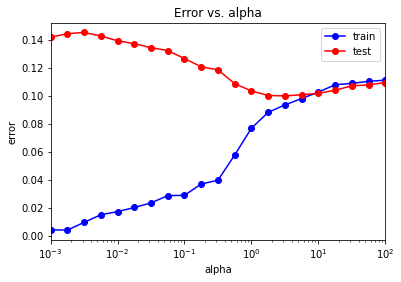

In [32]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

Как мы видим при достаточно большом alpha происходит переобучение и ошибка возрастает.

### Рассмотрим как у нас менялась метрика в зависимости от гиперпараметра:

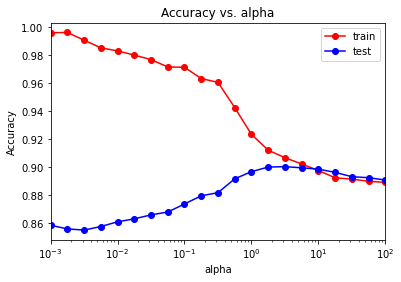

In [33]:
plt.semilogx(alpha_arr, train_acc, 'r-o', label = 'train')
plt.semilogx(alpha_arr, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Accuracy vs. alpha')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()

Минимальное значение ошибки:

In [27]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.003951869765247139 0.09979651419976997


Оптимальное значение alpha:

In [28]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[3.16227766]


### Зависимость ошибки на обучающей и тестовой выборках от количества нейронов при оптимальном alpha:

In [32]:
from sklearn.metrics import accuracy_score
neuron_arr = np.logspace(1, 2, 10)
neuron_arr=neuron_arr.astype('int')
test_err1 = []
train_err1 = []
train_acc1 = []
test_acc1 = []

for neuro in neuron_arr:
    
    mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (neuro,), 
                              solver = 'lbfgs', activation = 'logistic', max_iter=100000, random_state = 54)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err1.append(np.mean(y_train != y_train_pred))
    test_err1.append(np.mean(y_test != y_test_pred))
    train_acc1.append(accuracy_score(y_train, y_train_pred))
    test_acc1.append(accuracy_score(y_test, y_test_pred))

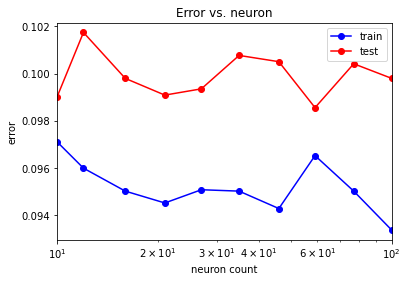

In [33]:
plt.semilogx(neuron_arr, train_err1, 'b-o', label = 'train')
plt.semilogx(neuron_arr, test_err1, 'r-o', label = 'test')
plt.xlim([np.min(neuron_arr), np.max(neuron_arr)])
plt.title('Error vs. neuron')
plt.xlabel('neuron count')
plt.ylabel('error')
plt.legend()

Как мы можем заметить на графике, оптимальным кол-вом нейронов в слое является 59

### Классификатор при найденном оптимальном значении alpha и оптимальном количестве нейронов:

In [18]:
alpha_opt = 3.16227766
neuron_opt=59

In [19]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (neuron_opt,),
                          solver = 'lbfgs', activation = 'logistic', max_iter=100000, random_state = 54)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print(np.mean(y_train != y_train_pred))
print(np.mean(y_test != y_test_pred))

0.0961425032440722
0.09961957002565691


#### Матрица рассогласования:

In [20]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_pred, y_test))

[[9672  813]
 [ 313  505]]


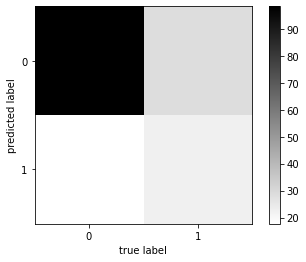

In [21]:
M = confusion_matrix(y_test_pred, y_test)
M = np.sqrt(M)
plt.imshow(M, interpolation = 'nearest')
plt.set_cmap('binary')
plt.xticks(range(2))
plt.yticks(range(2))
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.colorbar()
pass

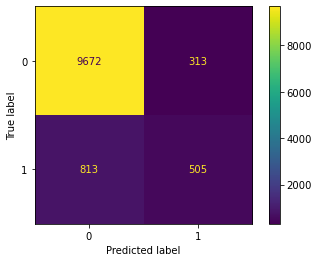

In [22]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(mlp_model, X_test, y_test) 

#### Точность предугадывания определенного ответа:

In [23]:
from sklearn.metrics import roc_curve


from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      9985
           1       0.62      0.38      0.47      1318

    accuracy                           0.90     11303
   macro avg       0.77      0.68      0.71     11303
weighted avg       0.89      0.90      0.89     11303



#### ROC-кривая

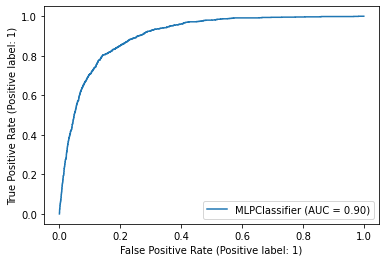

In [24]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(mlp_model, X_test, y_test)

### Подберем оптимальное значение параметра регуляризации alpha при двух слоях:

In [34]:
from sklearn.metrics import accuracy_score
alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100,100,),
                              solver = 'lbfgs', activation = 'logistic', max_iter=100000, random_state = 54)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

Зависимость ошибки на обучающей выборке и тестовой выборках от параметра alpha:

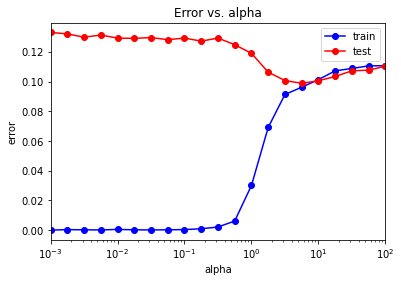

In [35]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

Как мы видим при достаточно большом alpha происходит переобучение и ошибка возрастает.

### Рассмотрим как у нас менялась метрика в зависимости от гиперпараметра:

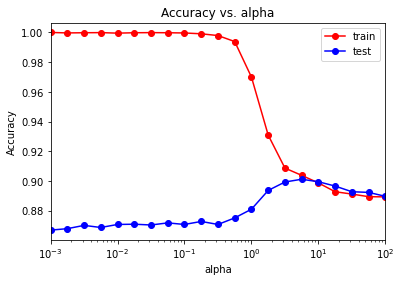

In [36]:
plt.semilogx(alpha_arr, train_acc, 'r-o', label = 'train')
plt.semilogx(alpha_arr, test_acc, 'b-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Accuracy vs. alpha')
plt.xlabel('alpha')
plt.ylabel('Accuracy')
plt.legend()

Минимальное значение ошибки:

In [37]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.0 0.0988233212421481


Оптимальное значение alpha:

In [38]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[5.62341325]


### Зависимость ошибки на обучающей и тестовой выборках от количества нейронов в 2х слоях при оптимальном alpha:

In [43]:
from sklearn.metrics import accuracy_score
neuron_arr = np.logspace(1, 2, 10)
neuron_arr=neuron_arr.astype('int')
test_err1 = []
train_err1 = []
train_acc1 = []
test_acc1 = []

for neuro in neuron_arr:
    
    mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (neuro,neuro,), 
                              solver = 'lbfgs', activation = 'logistic', max_iter=100000, random_state = 54)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err1.append(np.mean(y_train != y_train_pred))
    test_err1.append(np.mean(y_test != y_test_pred))
    train_acc1.append(accuracy_score(y_train, y_train_pred))
    test_acc1.append(accuracy_score(y_test, y_test_pred))

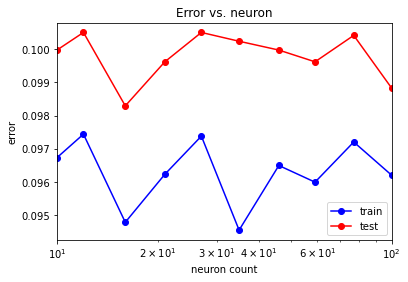

In [44]:
plt.semilogx(neuron_arr, train_err1, 'b-o', label = 'train')
plt.semilogx(neuron_arr, test_err1, 'r-o', label = 'test')
plt.xlim([np.min(neuron_arr), np.max(neuron_arr)])
plt.title('Error vs. neuron')
plt.xlabel('neuron count')
plt.ylabel('error')
plt.legend()

Как мы можем заметить на графике, оптимальным кол-вом нейронов в 2х слоях является 16

### Классификатор при найденном оптимальном значении alpha и оптимальном количестве нейронов в 2х слоях:

In [34]:
alpha_opt=5.62341325
neuron_opt=16

In [35]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (neuron_opt,neuron_opt,),
                          solver = 'lbfgs', activation = 'logistic',max_iter=100000, random_state = 54)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print(np.mean(y_train != y_train_pred))
print(np.mean(y_test != y_test_pred))

0.09493334906216822
0.0985579049809785


#### Матрица рассогласования:

In [36]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_pred, y_test))

[[9672  801]
 [ 313  517]]


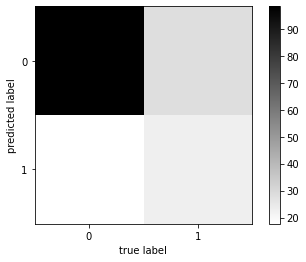

In [37]:
M = confusion_matrix(y_test_pred, y_test)
M = np.sqrt(M)
plt.imshow(M, interpolation = 'nearest')
plt.set_cmap('binary')
plt.xticks(range(2))
plt.yticks(range(2))
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.colorbar()
pass

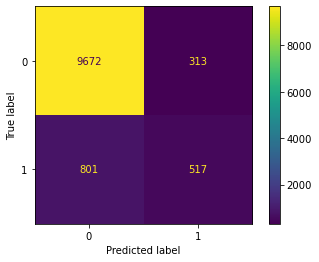

In [38]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(mlp_model, X_test, y_test) 

#### Точность предугадывания определенного ответа:

In [29]:
from sklearn.metrics import roc_curve


from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      9985
           1       0.62      0.39      0.48      1318

    accuracy                           0.90     11303
   macro avg       0.77      0.68      0.71     11303
weighted avg       0.89      0.90      0.89     11303



#### ROC-кривая

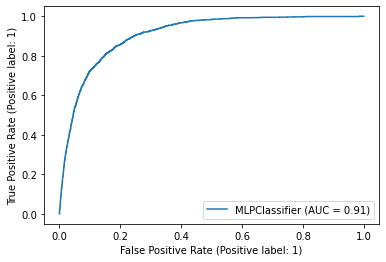

In [30]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(mlp_model, X_test, y_test)

## Вывод

Оптимальное число нейронов при одном слое 59 при это ошибка составила ~0.099. При двух слоях оптимальное число нейронов 16 при этом ошибка составила ~0.098. Значение ошибки не особо отличается от вычисленной ошибки с использованием различных классификаторов. Так же на основе таблицы точности можно заметить, что точность того, нейронная сеть угадает, что клиент не подпишется на срочный депозит выше и составляет 0,92. 